**ADA Project** \
**Group: WorkingTeam2023** \
Autumn semester 2023 

Milestone P2: from point 0 to point 5\
Milestone P3: from point 6 onwards

In [10]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import tqdm

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp
import networkx as nx

from scipy import stats

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import pyLDAvis.gensim_models
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from gensim.utils import simple_preprocess

from empath import Empath

import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 0. Loading the data

In [2]:
#load data/moviesummaries/character.metadata.tsv
character_metadata = pd.read_csv('../data/moviesummaries/character.metadata.tsv', sep='\t', header=None)

#load data/moviesummaries/plot_summaries.txt
plot_summaries = pd.read_csv('../data/moviesummaries/plot_summaries.txt', sep='\t', header=None)

#load data/moviesummaries/movie.metadata.tsv
movie_metadata = pd.read_csv('../data/moviesummaries/movie.metadata.tsv', sep='\t', header=None)

#load data/moviesummaries/name.clusters.txt
name_clusters = pd.read_csv('../data/moviesummaries/name.clusters.txt', sep='\t', header=None)


In [3]:
# Rename columns of each dataset to match documentation
character_metadata.columns = ["Wikipedia movie ID", "Freebase movie ID", "Movie release date", "Character name", "Actor date of birth", "Actor gender", 
                              "Actor height", "Actor ethnicity", "Actor name", "Actor age", "Freebase character/actor map ID", 
                              "Freebase character ID", "Freebase actor ID"]

plot_summaries.columns = ["Wikipedia movie ID", "Summary"]

movie_metadata.columns = ["Wikipedia movie ID", "Freebase movie ID", "Movie name", "Movie release date", "Movie revenue", "Movie runtime",
                          "Movie languages", "Movie countries", "Movie genres"]

name_clusters.columns = ["Character name", "Freebase character/actor map ID"]

We get 4 different dataframes; we'll merge movie_metadata and plot_summaries together since it makes sense to get the plot information directly linked with the movie metadata, and keep the others as is.

# 1. Preprocessing plot and metadata about movies

We can see from the columns name that we can simply add the plot summaries of the movies to the movie metadata dataframe. Let's first take a look at how many data we have in each dataset :

In [4]:
# Print the size of plot and meta_data dataset
print("Number of data in the metadata dataframe :", movie_metadata.shape[0])
print("Number of data in the plot summaries dataframe :", plot_summaries.shape[0])

Number of data in the metadata dataframe : 81741
Number of data in the plot summaries dataframe : 42303


We can see that approximately half of the movies in the metadata have a plot description. Let's first check if 'Wikipedia movie ID' can be used as a unique key to merge the two dataframes :

In [5]:
# Find out how many duplicates there are in the datasets
print("Numbers of duplicated Wikipedia movie ID in the metadata dataframe : ", movie_metadata["Wikipedia movie ID"].duplicated().sum())
print("Numbers of duplicated Wikipedia movie ID in the plot summaries dataframe : ", plot_summaries["Wikipedia movie ID"].duplicated().sum())

Numbers of duplicated Wikipedia movie ID in the metadata dataframe :  0
Numbers of duplicated Wikipedia movie ID in the plot summaries dataframe :  0


We can see that there are no duplicates in the Wikipedia movie ID column, so we can use it as a unique key to merge the two dataframes. Let's do it; We merge the two dataframes 'left' on the Wikipedia movie ID column, so that we keep all the movies in the metadata dataframe, even those that doesn't have a plot description.

In [6]:
# Merge 'left' the movie_metadata and plot_summaries dataframes on the Wikipedia movie ID column
all_movies = movie_metadata.merge(plot_summaries, on="Wikipedia movie ID", how="left")
all_movies.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."


In [7]:
# Check the number and percentage of null values in each column of all_movies as well as the number of different values in each column.
all_movies_null = pd.DataFrame(all_movies.isnull().sum(), columns=['Number of null values'])
all_movies_null['Percentage of null values'] = all_movies_null['Number of null values'] / len(all_movies)
all_movies_null['Number of unique values'] = all_movies.nunique()

print(all_movies.shape)
all_movies_null


(81741, 10)


,Number of null values,Percentage of null values,Number of unique values
Wikipedia movie ID,0,0.000000,81741
Freebase movie ID,0,0.000000,81741
Movie name,0,0.000000,75478
Movie release date,6902,0.084437,20389
Movie revenue,73340,0.897224,7362
Movie runtime,20450,0.250180,597
Movie languages,0,0.000000,1817
Movie countries,0,0.000000,2124
Movie genres,0,0.000000,23817
Summary,39537,0.483686,42196


As mentioned above, we see that approximately 48% percent of the movie dataset doesn't have a corresponding plot summary!

But what about dupplicated plot summaries? It's very unlikely that 2 movies have the exact same entry, but let's check that :

In [8]:
# Show plot summary duplicates which are not NaNs
duplicate_plot_movies = all_movies[all_movies.duplicated(subset=['Summary'], keep = False) & all_movies['Summary'].notnull()]

# Print number of plot summaries having at least one duplicate
print("Number of plot summaries having at least one duplicate :", duplicate_plot_movies['Summary'].nunique())

duplicate_plot_movies[['Wikipedia movie ID', 'Movie name', 'Summary']].sort_values(by=['Summary'])


Number of plot summaries having at least one duplicate : 5


,Wikipedia movie ID,Movie name,Summary
4551,14055212,The Trial of Madame X,A woman is thrown out of her home by her jealo...
18993,14022275,Madame X,A woman is thrown out of her home by her jealo...
49381,14037732,Madame X,A woman is thrown out of her home by her jealo...
57569,14051944,Madame X,A woman is thrown out of her home by her jealo...
65014,14053389,Madame X,A woman is thrown out of her home by her jealo...
28621,29481480,Drohi,An orphan Raghav turns into a ruthless contrac...
67464,25493367,Antham,An orphan Raghav turns into a ruthless contrac...
15783,14616220,The Warrens of Virginia,"As the American Civil War begins, Ned Burton l..."
57508,28852030,The Warrens of Virginia,"As the American Civil War begins, Ned Burton l..."
22185,19609453,Amar Deep,Raja was adopted by a criminal don at a very ...


We see that there are 5 different plot summaries that have at least one duplicate! In some cases, the duplicate has the same movie name but in other cases, the duplicate has a different movie name. To try to catch the real duplicates, we'll search for rows that share all the same columns except the IDs columns.

In [9]:
# Check for duplicates on all columns except for the ID columns
check_duplicates = all_movies[all_movies.duplicated(subset=["Movie name", "Movie release date", "Movie revenue", "Movie languages", "Movie genres", "Movie countries", "Movie runtime", "Summary"], keep=False)]

check_duplicates.sort_values(by=["Movie name"])

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary
35927,33545359,/m/0hgm4mx,A Sister to Assist 'Er,NaN,NaN,NaN,{},{},"{""/m/05p553"": ""Comedy film""}",NaN
77623,33545325,/m/0hgpm4_,A Sister to Assist 'Er,NaN,NaN,NaN,{},{},"{""/m/05p553"": ""Comedy film""}",NaN
640,32505827,/m/0h1cbks,Dost,NaN,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}",{},NaN
75111,32517667,/m/0h1dthj,Dost,NaN,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}",{},NaN
7009,9386528,/m/0286tgz,Horizontal Axis,NaN,NaN,NaN,{},{},"{""/m/02hmvc"": ""Short Film""}",NaN
79631,9386447,/m/0286tdx,Horizontal Axis,NaN,NaN,NaN,{},{},"{""/m/02hmvc"": ""Short Film""}",NaN
9911,20695929,/m/051zsk3,My Wife's Family,NaN,NaN,NaN,{},"{""/m/07ssc"": ""United Kingdom""}","{""/m/01z4y"": ""Comedy""}",NaN
22389,20696066,/m/051zc20,My Wife's Family,NaN,NaN,NaN,{},"{""/m/07ssc"": ""United Kingdom""}","{""/m/01z4y"": ""Comedy""}",NaN
6010,31255600,/m/0gjb35n,Woman to Woman,NaN,NaN,NaN,{},{},"{""/m/02l7c8"": ""Romance Film"", ""/m/07s9rl0"": ""D...",NaN
53387,31255791,/m/0gjf1sq,Woman to Woman,NaN,NaN,NaN,{},{},"{""/m/02l7c8"": ""Romance Film"", ""/m/07s9rl0"": ""D...",NaN


We notice that those films have a lot of NaN values, but since they share all the same values we don't have a valid reason not to drop them. That's why we chose to drop one of each pair.

In [10]:
# drop one of each pair of duplicates
all_movies.drop_duplicates(subset=["Movie name", "Movie release date", "Movie revenue", "Movie languages", "Movie genres", "Movie countries", "Movie runtime", "Summary"], inplace=True, keep="first")

## Data cleaning

### Movie release date


Let's now take a look at the movies release dates. By looking at the data, we see 4 cases :
 - The release date is a year 
 - The release date is a month and a year 
 - The release date is a day, a month and a year 
 - The release date is not a number

Let's convert every entry to only a year when it's possible :

In [11]:
character_metadata.sample(10)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
143146,10620698,/m/02qkfwk,1979-03-24,NaN,NaN,M,NaN,NaN,Hsi Chang,NaN,/m/0lb9x7f,NaN,/m/0gcgvfj
302653,32895002,/m/0bxl4t_,1911,NaN,NaN,NaN,NaN,NaN,H. Parker,NaN,/m/0bxl4xh,NaN,/m/0bxl4xd
210400,5085287,/m/0d1_ps,1977,Manny Durrell,1927-02-20,M,1.892,/m/0x67,Sidney Poitier,49.0,/m/03llh4j,/m/0h1q4s1,/m/0cgzj
202213,30535572,/m/0cs2pv9,1975,NaN,1955-10-29,F,NaN,NaN,Etsuko Shihomi,19.0,/m/0gcb8l4,NaN,/m/0405m93
364143,33047559,/m/0h557yx,2011-05-18,NaN,NaN,M,NaN,NaN,Ahmed El Feshawy,NaN,/m/0j_xz51,NaN,/m/0gcjzz9
282595,6862788,/m/0gt3gk,1995,NaN,NaN,NaN,NaN,NaN,Stanley Herman,NaN,/m/0gc4tlp,NaN,/m/0gc1pnr
97028,3356331,/m/097g5z,2004-10-15,Satya Prasad,1938-05-19,M,NaN,/m/0d9q7j,Girish Karnad,66.0,/m/02vbpxj,/m/0h75gdd,/m/04ch23
275874,23510371,/m/06w36vy,NaN,NaN,1980-02-28,F,NaN,/m/01rv7x,Padmapriya Janakiraman,NaN,/m/0h79w7d,NaN,/m/0cb1h4
418473,4199759,/m/0bpl1z,2001-10-06,NaN,1953-11-01,M,NaN,NaN,Kenjiro Ishimaru,47.0,/m/02vblyn,NaN,/m/026g6tw
266066,20589066,/m/0522z10,2011-12-02,Orderly,NaN,M,NaN,NaN,Bernard Caraviello Jr.,NaN,/m/0k19dp8,/m/0k19gb6,/m/0k19dpc


Converting the movie release date to keep only the year for the all_movie table :

In [12]:
all_movies = keep_the_year(all_movies, key='Movie release date')

### Dictionnary structures

In [13]:
# Print examples of the 'Movie countries', 'Movie genres' and 'Movie languages' columns as well as their types
print(all_movies['Movie countries'].iloc[0])
print(type(all_movies['Movie countries'].iloc[0]))
print(all_movies['Movie genres'].iloc[0])
print(type(all_movies['Movie genres'].iloc[0]))
print(all_movies['Movie languages'].iloc[0])
print(type(all_movies['Movie languages'].iloc[0]))

{"/m/09c7w0": "United States of America"}
<class 'str'>
{"/m/01jfsb": "Thriller", "/m/06n90": "Science Fiction", "/m/03npn": "Horror", "/m/03k9fj": "Adventure", "/m/0fdjb": "Supernatural", "/m/02kdv5l": "Action", "/m/09zvmj": "Space western"}
<class 'str'>
{"/m/02h40lc": "English Language"}
<class 'str'>


We see that some columns are written as a dictionnary but saved as a string. 

Three columns are concerned by this problem:
- Movie languages (Freebase ID:name tuples)
- Movie countries (Freebase ID:name tuples)
- Movie genres (Freebase ID:name tuples)

Since we will not use the Freebase IDs, let's only keep the values of these dicts as lists.

In [14]:
all_movies['Movie genres'] = [list(eval(genre).values()) for genre in all_movies['Movie genres']]
all_movies['Movie languages'] = [list(eval(genre).values()) for genre in all_movies['Movie languages']]
all_movies['Movie countries'] = [list(eval(genre).values()) for genre in all_movies['Movie countries']]
print(all_movies['Movie countries'].iloc[0])
print(type(all_movies['Movie countries'].iloc[0]))
print(all_movies['Movie genres'].iloc[0])
print(type(all_movies['Movie genres'].iloc[0]))
print(all_movies['Movie languages'].iloc[0])
print(type(all_movies['Movie languages'].iloc[0]))

['United States of America']
<class 'list'>
['Thriller', 'Science Fiction', 'Horror', 'Adventure', 'Supernatural', 'Action', 'Space western']
<class 'list'>
['English Language']
<class 'list'>


Now, we have a proper dataframe containing metadata and plot summaries about movies: all_movies

# 2. Preprocessing characters metadata

In [15]:
character_metadata.sample(10)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
312386,1994218,/m/06cky2,2004,NaN,1967-05-20,M,NaN,NaN,Gosha Kutsenko,36.0,/m/0gj3fgy,NaN,/m/0h7q0m4
180513,27381879,/m/0bx_bqp,1949-10-12,Moe,1897-06-19,M,1.62,NaN,Moe Howard,NaN,/m/0byl3rq,/m/0h577m2,/m/02cvp8
211224,32864663,/m/09pgl3j,1952-01-16,Anton,1914-11-08,M,NaN,NaN,Norman Lloyd,37.0,/m/0hpq52j,/m/0hpq538,/m/0fsrjj
420071,13651753,/m/03cd35c,2007-10-02,Sergey,1964-06-03,M,NaN,NaN,Aleksey Serebryakov,43.0,/m/0jwdmxp,/m/0jwdmxs,/m/0cjbz1q
257983,12685170,/m/02x0fs9,2007-09-10,Choir Member #3,NaN,F,NaN,NaN,Annabelle Torsein,NaN,/m/0bj4ht2,/m/0bj4ht5,/m/0bj4htd
82070,3401395,/m/099mch,1945,NaN,1908-02-22,M,1.73,/m/02w7gg,John Mills,36.0,/m/03lf6kd,NaN,/m/0141kz
345134,23491875,/m/06w6849,2009-06-15,NaN,NaN,NaN,NaN,NaN,Eri Shinmoto,NaN,/m/0gc_1n4,NaN,/m/0gczdc3
47639,1955275,/m/068qkb,1995-07-15,NaN,1965-02-13,M,NaN,NaN,Hiro Yuki,30.0,/m/0k86dm,NaN,/m/03czh4
53710,18736956,/m/04gsymx,1925-12-07,Clarke's Fiancee,1903,F,NaN,NaN,Alice Laidley,22.0,/m/0n4n4fh,/m/0n4n4fl,/m/0n4n4ft
83203,6309072,/m/0g0dy6,1991,NaN,1937-04-13,M,1.73,NaN,Edward Fox,53.0,/m/0ggb_4_,NaN,/m/01xsbh


Taking a quick look, we see that we encounter the same problem with the "Movie release date" and " Actor date of birth" as seen before. Let's convert every entry to only a year when it's possible :

In [16]:
character_metadata = keep_the_year(character_metadata, key='Movie release date')
character_metadata = keep_the_year(character_metadata, key='Actor date of birth')

# 3. Learning more about the data

### Chronological evolution of movie production

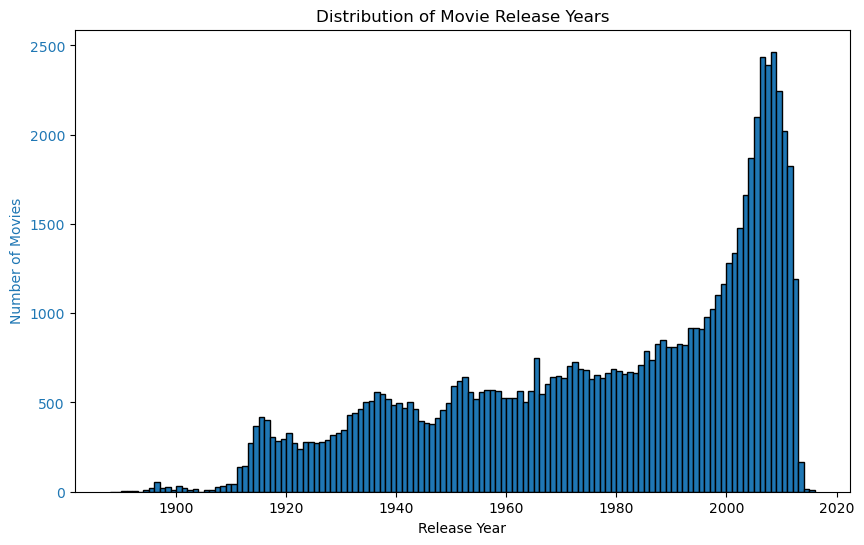

In [17]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Creating an histogram plotting the values of 'year'
ax1.hist(all_movies['Movie release date'].dropna(), bins=range(int(all_movies['Movie release date'].min()), int(all_movies['Movie release date'].max()) + 1), edgecolor='black', label='Movie Releases')
ax1.set_xlabel('Release Year')
ax1.set_ylabel('Number of Movies', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

plt.title('Distribution of Movie Release Years')
plt.show()

Looking at the plot we can see that we have more data for recent films.

### Movie countries and genres

We compute the top 10 countries and genres. For co-produced movies, we count an additional movie per co-producing country. For example, a movie co-produced by the USA and India will add +1 movie produced for both of these countries. The same logic applies for the movie genres.

In [18]:
# Print number of unique movie countries, genres and languages

unique_countries_list = all_movies['Movie countries'].explode().unique()
unique_genres_list = all_movies['Movie genres'].explode().unique()
unique_languages_list = all_movies['Movie languages'].explode().unique()

print('Number of unique movie countries:', len(unique_countries_list))
print('Number of unique movie genres:', len(unique_genres_list))
print('Number of unique movie languages:', len(unique_languages_list))

Number of unique movie countries: 148
Number of unique movie genres: 364
Number of unique movie languages: 208


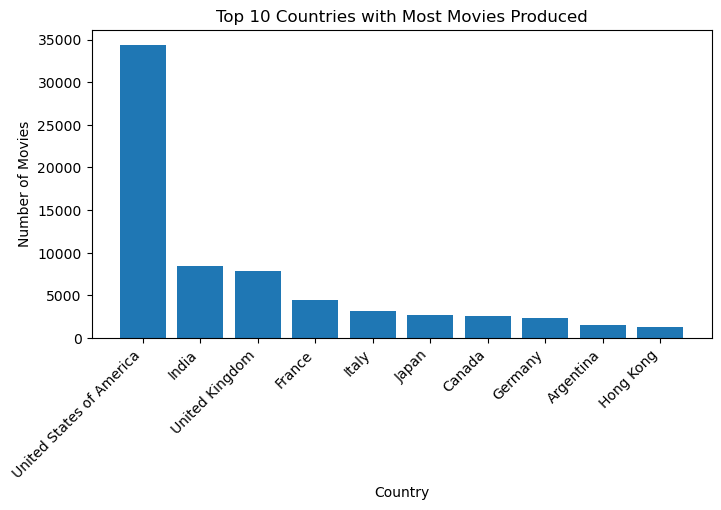

The top production country is United States of America and concerns 39.81% of all movies produced.


In [19]:
# Compute a box plot of top 10 countries with most movies produced or coproduced
country_counts = {}

for countries in all_movies['Movie countries']:
    for country in countries:
        if country in country_counts:
            country_counts[country] += 1
        else:
            country_counts[country] = 1

# Get the top 10 countries
top_countries = sorted(country_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Create a new DataFrame with the top countries
top_countries_df = pd.DataFrame(top_countries, columns=['Country', 'Count'])

# Bar plot
plt.figure(figsize=(8, 4))
plt.bar(top_countries_df['Country'], top_countries_df['Count'])
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.title('Top 10 Countries with Most Movies Produced')
plt.xticks(rotation=45, ha='right')
plt.show()

# Print the top 1 country and its percentage
top_1_country = top_countries_df['Country'].iloc[0]
percentage = country_counts[top_1_country] / sum(country_counts.values()) * 100
print(f'The top production country is {top_1_country} and concerns {percentage:.2f}% of all movies produced.')

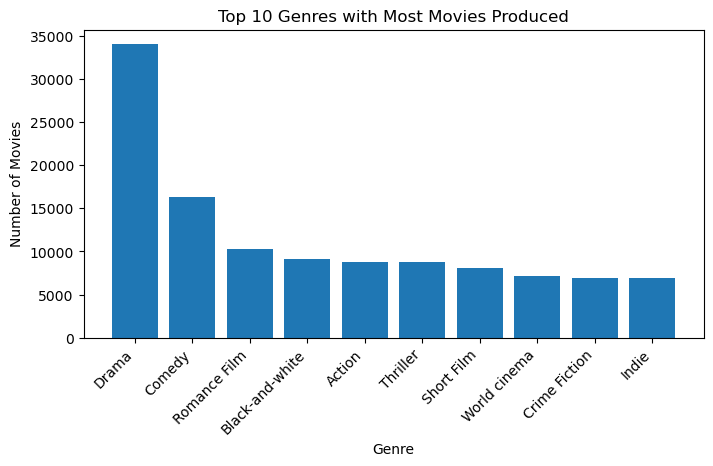

The top genre is Drama and represents 13.98% of all movies produced.


In [20]:
# Compute a box plot of top 10 genres with most movies produced
genre_counts = {}

for genres in all_movies['Movie genres']:
    for genre in genres:
        if genre in genre_counts:
            genre_counts[genre] += 1
        else:
            genre_counts[genre] = 1

# Get the top 10 genres
top_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Create a new DataFrame with the top genres
top_genres_df = pd.DataFrame(top_genres, columns=['Genre', 'Count'])

# Bar plot
plt.figure(figsize=(8, 4))
plt.bar(top_genres_df['Genre'], top_genres_df['Count'])
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Top 10 Genres with Most Movies Produced')
plt.xticks(rotation=45, ha='right')
plt.show()

# Print the top 1 genre and its percentage
top_1_genre = top_genres_df['Genre'].iloc[0]
percentage = genre_counts[top_1_genre] / sum(genre_counts.values()) * 100
print(f'The top genre is {top_1_genre} and represents {percentage:.2f}% of all movies produced.')

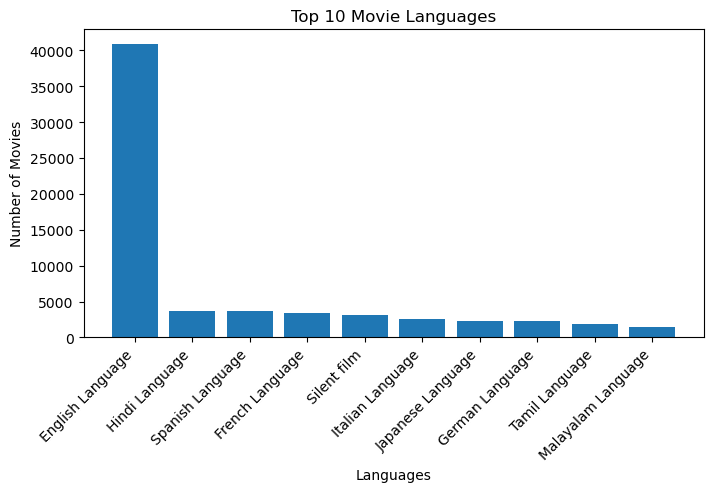

The top language is "English Language" and represents 50.29% of all movies produced.


In [21]:
# Compute a box plot of top 10 genres with most movies produced
language_counts = {}

for languages in all_movies['Movie languages']:
    for language in languages:
        if language in language_counts:
            language_counts[language] += 1
        else:
            language_counts[language] = 1

# Get the top 10 genres
top_languages = sorted(language_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Create a new DataFrame with the top genres
top_languages_df = pd.DataFrame(top_languages, columns=['Language', 'Count'])

# Bar plot
plt.figure(figsize=(8, 4))
plt.bar(top_languages_df['Language'], top_languages_df['Count'])
plt.xlabel('Languages')
plt.ylabel('Number of Movies')
plt.title('Top 10 Movie Languages')
plt.xticks(rotation=45, ha='right')
plt.show()

# Print the top 1 genre and its percentage
top_1_language = top_languages_df['Language'].iloc[0]
percentage = language_counts[top_1_language] / sum(language_counts.values()) * 100
print(f'The top language is "{top_1_language}" and represents {percentage:.2f}% of all movies produced.')


These results show us that an analysis of the whole dataset will actually be more representative of movies produced or co-produced in the USA, movies belonging to the genre Drama and movies in english. The reason why the percentage of english movies is so high is not only because the USA is the largest producing country but also because a lot of movies might be translated in english.

## Missing values

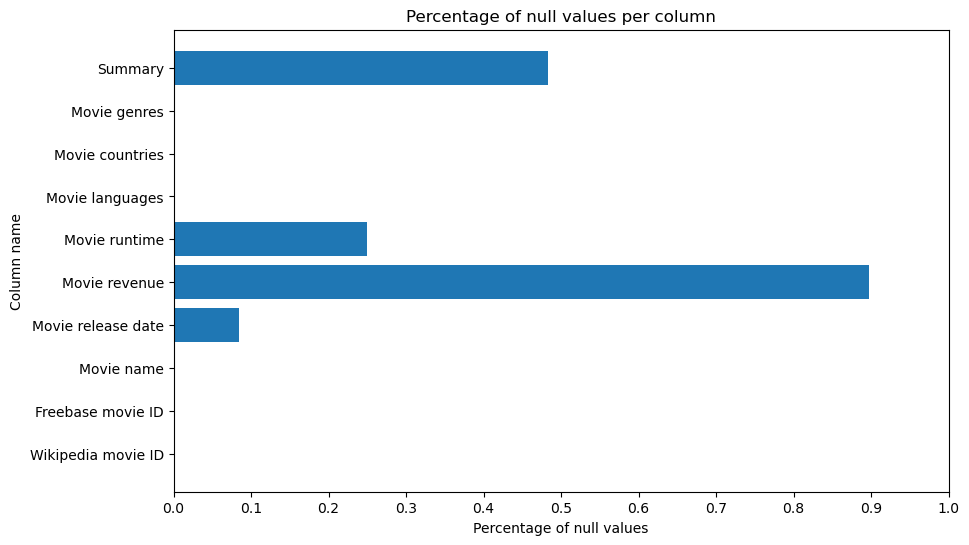

Percentage of missing values in movie revenue: 89.72%


In [22]:
# plot the percentage of missing values for all columns in the all_movies dataframe
plt.figure(figsize=(10, 6))
plt.barh(all_movies_null.index, all_movies_null['Percentage of null values'])
plt.xlabel('Percentage of null values')
plt.ylabel('Column name')
plt.xticks(ticks=np.arange(0, 1.1, 0.1))
plt.title('Percentage of null values per column')
plt.show()

print(f"Percentage of missing values in movie revenue: {100*all_movies_null['Percentage of null values']['Movie revenue']:.2f}%")

We see that there are a lot of missing values of the movie revenues (around 90%), we need to find another metric for judging films popularity. IMDb ratings seem to be a good alternative. This dataset contains the average IMDb rating of movies and the number of votes.

# 4. Add IMDb ratings

### Load the data

In [23]:
movie_ratings = pd.read_csv('../data/title.ratings.tsv', sep='\t', header=0)

In [24]:
movie_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2006
1,tt0000002,5.8,269
2,tt0000003,6.5,1909
3,tt0000004,5.5,178
4,tt0000005,6.2,2689


### Use Wikidata query to create a table that links IMDb identifier tconst with Freebase ID

Since multiple movies have the same name and appear the same year, we have to link the two dataset using freebase ID of the movies in the original dataset and the unique identifier tconst of the IMDb ratings dataset. We use Wikidata query to create a link table

In [25]:
# Create the table
link_id = link_tconst_freebaseID()

# Drop duplicates
link_id = link_id.drop_duplicates(subset=['tconst'])
link_id = link_id.drop_duplicates(subset=['Freebase movie ID'])

link_id.head()

,tconst,Freebase movie ID
0,nm0210701,/m/04yg98
1,nm1295718,/m/03cf2r1
2,nm0648260,NaN
4,nm0309410,/m/010hr9vb
5,nm0502403,/m/0dctw


### Merge the two datasets

In [26]:
# Add freebase ID to movie_ratings
movie_ratings = pd.merge(movie_ratings, link_id, on='tconst', how='left')
movie_ratings.head()

,tconst,averageRating,numVotes,Freebase movie ID
0,tt0000001,5.7,2006,/m/0kvdsy
1,tt0000002,5.8,269,/m/02pz844
2,tt0000003,6.5,1909,/m/0g53g2
3,tt0000004,5.5,178,/m/02pzdsc
4,tt0000005,6.2,2689,/m/0jq3g


In [27]:
# Merge all_movies and movie_ratings
all_movies = pd.merge(all_movies, movie_ratings, on='Freebase movie ID', how='left')
# Drop tconst column
all_movies.drop(columns=['tconst'], inplace=True)

all_movies.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",4.9,56908.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",NaN,6.0,69.0
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",NaN,5.6,40.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,6.1,2895.0
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra...",5.9,623.0


In [28]:
# Percentage of missing values in the columns averageRatings and num votes
print('Percentage of missing values in averageRatings: {:.2f}%'.format(100 * all_movies['averageRating'].isnull().sum() / len(all_movies)))
print('Percentage of missing values in numVotes: {:.2f}%'.format(100 * all_movies['numVotes'].isnull().sum() / len(all_movies)))

Percentage of missing values in averageRatings: 16.99%
Percentage of missing values in numVotes: 16.99%


We have far fewer missing values in ratings than in revenues.

### Correlation between movie revenue and average rating

Percentage of movies for which we have both informations: 10.18% 
 

Person correlation between movie revenue and average rating:  PearsonRResult(statistic=0.16827121878890383, pvalue=6.415827841218538e-54) 
 



/Users/clarawetzel/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


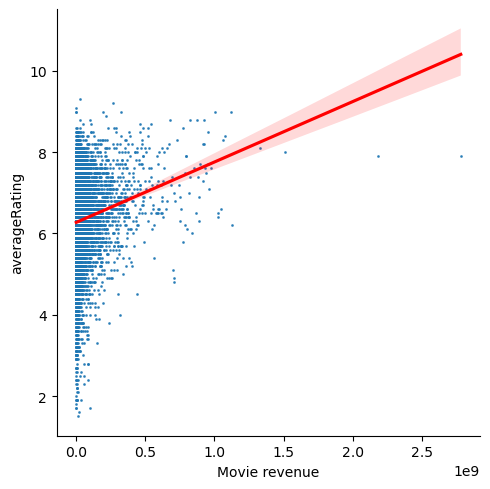

In [29]:
# Keep movies for which we have both informations
df1 = all_movies.dropna(subset=['Movie revenue', 'averageRating'])

# What percentage of the whole dataset does it represent
print("Percentage of movies for which we have both informations: {:.2f}%".format(100 * len(df1) / len(all_movies)), '\n', '\n')

# Pearson correlation between the movie revenue and the average rating
df1_pearson = stats.pearsonr(df1['Movie revenue'], df1['averageRating'])
print("Person correlation between movie revenue and average rating: ", df1_pearson, '\n', '\n')

# Plot the correlation between the movie revenue and the average rating
sns.lmplot(x='Movie revenue', y='averageRating', data=df1, scatter_kws={"s": 1}, line_kws={'color': 'red'})

There is a significant positive correlation between a movie revenue and its average rating.

### Correlation between movie revenue and number of votes for rating

Percentage of movies for which we have both informations: 10.18% 
 

Person correlation between movie revenue and numVotes:  PearsonRResult(statistic=0.6549975631261226, pvalue=0.0) 
 



/Users/clarawetzel/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


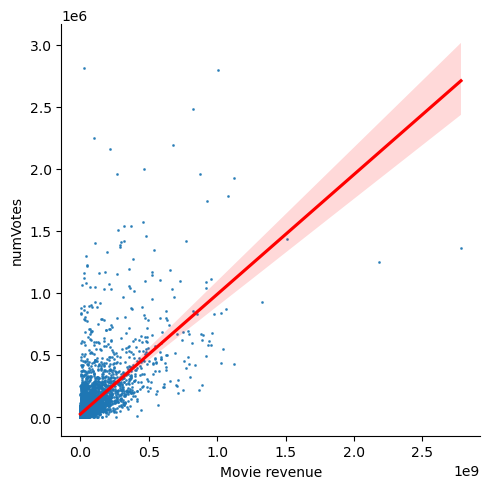

In [30]:
# Keep movies for which we have both informations
df2 = all_movies.dropna(subset=['Movie revenue', 'numVotes'])

# What percentage of the whole dataset does it represent
print("Percentage of movies for which we have both informations: {:.2f}%".format(100 * len(df2) / len(all_movies)), '\n', '\n')

# Pearson correlation between the movie revenue and the average rating
df2_pearson = stats.pearsonr(df2['Movie revenue'], df2['numVotes'])
print("Person correlation between movie revenue and numVotes: ",df2_pearson, '\n', '\n')


# Plot the correlation between the movie revenue and the average rating
sns.lmplot(x='Movie revenue', y='numVotes', data=df2, scatter_kws={"s": 1}, line_kws={'color': 'red'})

There is a significant positive correlation between a movie revenue and its number of votes.

Looking at the previous graphs, the positive correlation between the data confirms that using the movie reviews and number of votes in a similar extent as the movie revenue is reasonable.

# 5. Correlation

Exploring possible correlatinos in our dataset.

### Movie release year - Movie average rating

/var/folders/60/n3wml7t139732y5n5jgc1bqc0000gn/T/ipykernel_43786/148172858.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Movie release date'] = df3['Movie release date'].astype(int)
/Users/clarawetzel/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)



 
 Percentage of movies for which we have both informations: 77.55% 
 

Person correlation between movie revenue and numVotes:  PearsonRResult(statistic=-0.055285506890018654, pvalue=4.2129930797222944e-44) 
 



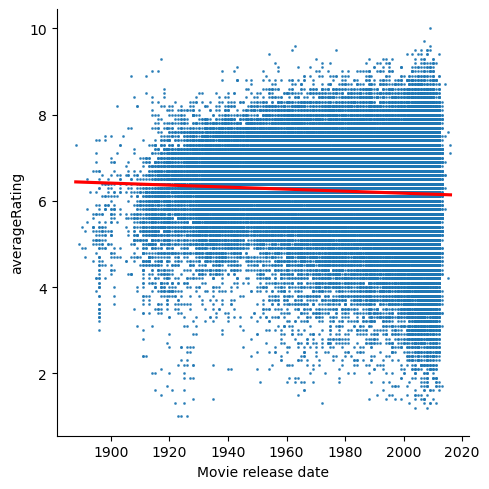

In [31]:
# Keep movies for which we have both informations
df3 = all_movies.dropna(subset=['Movie release date', 'averageRating'])
df3['Movie release date'] = df3['Movie release date'].astype(int)

# What percentage of the whole dataset does it represent
print('\n', '\n', "Percentage of movies for which we have both informations: {:.2f}%".format(100 * len(df3) / len(all_movies)), '\n', '\n')

# Pearson correlation between the movie revenue and the average rating
df3_pearson = stats.pearsonr(df3['Movie release date'], df3['averageRating'])
print("Person correlation between movie revenue and numVotes: ", df3_pearson, '\n', '\n')

# Plot the correlation between the movie revenue and the average rating
sns.lmplot(x='Movie release date', y='averageRating', data=df3, scatter_kws={"s": 1}, line_kws={'color': 'red'})

There is a significative but very weak negative correlation between the two variables.

# 6. NLP Topic detection

In order to point out the main themes in the movie plot summaries, we perform an NLP topic detection analysis. 

## Data cleaning

To perform NLP with a better performance, a few transformation and modification are needed on the summaries. \
We did the following transformations:
- Tokenization on white space
- Removal of punctuation
- Casefolding
- Stopword removal: based on the "english" stopword library from nltk
- Removal of common words in summaries: some words are very common in movie plot summaries (film, films, movie and movies) and don't bring a lot of additional informaiton, we decide to remove them
- Removal of common names: we realized that a lot of topic were described with first names. In our case, it doesn't bring any relevant information. We decide to remove a list of names taken from an internet source (https://data.world/davidam/international-names/workspace/data-dictionary )
- Lemmatization

These steps are made in the get_summaries() function available in the helpers file. This function creates the processes_summaries.tsv file which can be later used without re-running the function.\
The other steps of data cleaning detailed in milestone P2 are made through the get_cleaned_data() function for the sake of simplification.

In [2]:
path = '../data/'
all_movies_cleaned, character_metadata_cleaned, name_clusters_cleaned = get_cleaned_data(path)

# CLEANED movie summaries
all_movies_cleaned = all_movies_cleaned.dropna(subset=['Summary'])
all_movies_cleaned.head()


Loading the data...
Loading and cleaning the summaries...
Summaries loaded from processed_summaries.tsv
Cleaning the data...
Adding IMDb ratings...


,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",half century depicts planet terraformed allowi...,4.9,56908.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",series murder woman throughout distinctive sig...,6.1,2895.0
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],upper housewife becomes frustrated leaf arroga...,5.9,623.0
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,[English Language],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]",hundred year evil return claim fingall talisma...,NaN,NaN
12,6631279,/m/0gffwj,Little city,1997,NaN,93.0,[English Language],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...",work cab side hard committing girlfriend want ...,5.8,1129.0


## Topic detection

### Topic detection on the whole dataset

To start our analysis, we perform the topic detection on the whole cleaned dataset.

We see that setting the number of topics to 8 seems to give us the best results. Indeed, less topics give us results that are more vague and more than 8 topics results in overlapping topics.

In [ ]:
# Tokenize the text in the 'Summary' column
all_movies_cleaned['Summary_tokens'] = all_movies_cleaned['Summary'].apply(simple_preprocess)

# Create a dictionary from the movie summaries
dictionary = Dictionary(all_movies_cleaned['Summary_tokens'])

# Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(tokens) for tokens in all_movies_cleaned['Summary_tokens']]

# Set up the parameters
seed = 42
params = {'passes': 10, 'random_state': seed}

# Create the LDA model
model = LdaMulticore(corpus=corpus, num_topics=8, id2word=dictionary, workers=6,
                     passes=params['passes'], random_state=params['random_state'])

# plot topics
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

By setting the lambda at 0.5, we see that the main topic genre can be interpreted as:
- Topic 1: Drama and/or Relationships
- Topic 2: Horror
- Topic 3: Detective and/or Crime
- Topic 4: War
- Topic 5: Musical
- Topic 6: Western
- Topic 7: Supernatural
- Topic 8: Undefined, related to animals or creatures

We observe that the term 'war' is part of the top 30 most salient terms. Furthermore, one of the major societal fear, war, is very represented in our movies as it has a topic on its own.

### Topic detection on war movies

Since 'war' seems to be one of the societal fear that is the more represented in our dataset. Let's dive in a more precise analysis of this topic. To do this, we first need to select all the movies talking about war. We select movies that belong to a genre containing the word 'war' in it. \

Since war is already a topic of its own, we perform the topic detection on a smaller number of topic, 4.

In [ ]:
# Print all possible genres that contain the word "war"
print("All possible genres that contain the word 'war':", all_movies_cleaned['Movie genres'].apply(lambda x: [item for item in x if 'war' in item.lower()]).explode().unique())

# Select movies for which at least one genre in the list 'Movie genre' contain the word "war"
all_movies_genre_war = all_movies_cleaned[all_movies_cleaned['Movie genres'].apply(lambda x: any(item for item in x if 'war' in item.lower()))]

# Tokenize the text in the 'Summary' column
all_movies_genre_war['Summary_tokens'] = all_movies_genre_war['Summary'].apply(simple_preprocess)

# Create a dictionary from the movie summaries
dictionary = Dictionary(all_movies_genre_war['Summary_tokens'])

# Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(tokens) for tokens in all_movies_genre_war['Summary_tokens']]

# Set up the parameters
seed = 42
params = {'passes': 10, 'random_state': seed}

# Create the LDA model
model = LdaMulticore(corpus=corpus, num_topics=4, id2word=dictionary, workers=6,
                     passes=params['passes'], random_state=params['random_state'])

# plot topics
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

All possible genres that contain the word 'war': [nan 'War film' 'Gulf War' 'Anti-war' 'Anti-war film' 'Nuclear warfare'
 'Cold War' 'War effort' 'The Netherlands in World War II']


/var/folders/60/n3wml7t139732y5n5jgc1bqc0000gn/T/ipykernel_42600/1180759538.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_movies_genre_war['Summary_tokens'] = all_movies_genre_war['Summary'].apply(simple_preprocess)


### Topic detection on non-war movies

Movies about war seem to be very present in our dataset. Therefore, it is possible that this over-representation of this theme hides other themes about other societal fears. To take a closer look to other themes, let's remove the movies about war. \

Once again, since we are looking into a smaller dataset, we choose to perform the topic detection on 4 topics.

In [ ]:
# Select movies for which no genre in the list 'Movie genre' contain the word "war"
all_movies_genre_not_war = all_movies_cleaned[~all_movies_cleaned['Movie genres'].apply(lambda x: any(item for item in x if 'war' in item.lower()))]

# Tokenize the text in the 'Summary' column
all_movies_genre_not_war['Summary_tokens'] = all_movies_genre_not_war['Summary'].apply(simple_preprocess)

# Create a dictionary from the movie summaries
dictionary = Dictionary(all_movies_genre_not_war['Summary_tokens'])

# Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(tokens) for tokens in all_movies_genre_not_war['Summary_tokens']]

# Set up the parameters
seed = 42
params = {'passes': 10, 'random_state': seed}

# Create the LDA model
model = LdaMulticore(corpus=corpus, num_topics=4, id2word=dictionary, workers=6,
                     passes=params['passes'], random_state=params['random_state'])

# plot topics
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

/var/folders/60/n3wml7t139732y5n5jgc1bqc0000gn/T/ipykernel_42600/2726125112.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_movies_genre_not_war['Summary_tokens'] = all_movies_genre_not_war['Summary'].apply(simple_preprocess)


We can intepret the four topics title as:
- Topic 1: Drama and/or Relationships and/or Family
- Topic 2: Action
- Topic 3: Science-fiction and/or War
- Topic 4: Love and/or Bollywood movies

By looking at the words appearing in topic 3, we see that some societal fears could be represented the movies close to this topics.

### Smooth topic detection over time

In [ ]:
def weighted_bow(data, dictionary):
    # Aggregate the yearly bow into a dataframe with columns year, word_id, weight
    # where for each word_id, the weight is weighted sum of the distribution of the word in the yearly bow, centered around the year
    
    # Create a bow for each year  
    yearly_bow = []
    for year in data['Movie release date'].unique():
        year_agg = data[data['Movie release date'] == year]['Summary_tokens'].sum()
        bow = dictionary.doc2bow(year_agg)
        # make truples of (year, word_id, count)
        bow = [(word_id, year, count) for word_id, count in bow]
        yearly_bow.append(bow)

    # make a dataframe with the yearly bow
    yearly_bow = pd.DataFrame([item for sublist in yearly_bow for item in sublist], columns=['word_id', 'year', 'count'])
    
    # create a distribution lookup table for all the differences between two years
    years = data['Movie release date'].unique()
    distrib_weights = {}
    for diff in range(max(years) - min(years) + 1):
        distrib_weights[diff] = np.exp(-(diff)**2 / 1000)

    # aggregate the yearly bow into a dataframe with columns year, word_id, weight
    weights_df = pd.DataFrame(columns=['year', 'word_id', 'weight'])
    for year in tqdm.tqdm(years):
        # aggregate the yearly bow. Group by word_id and sum the counts using the weights from the distribution lookup table
        # custom aggregation function
        def weighted_sum(x):
            return np.sum(x['count'] * abs(x['year'] - year).map(distrib_weights))
        
        yearly_bow_agg = yearly_bow.groupby('word_id').apply(weighted_sum).reset_index()
        yearly_bow_agg.columns = ['word_id', 'weight']
        yearly_bow_agg['year'] = year
        weights_df = pd.concat([weights_df, yearly_bow_agg], axis=0)


    return weights_df

In [ ]:
#copy of all_movies_cleaned where we drop the rows with missing values in the 'Movie release date' column
all_movies_cleaned_copy = all_movies_cleaned.dropna(subset=['Movie release date'])

# Create a dictionary from the movie summaries
dictionary = Dictionary(all_movies_cleaned_copy['Summary_tokens'])

# Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(tokens) for tokens in all_movies_cleaned_copy['Summary_tokens']]

# Set up the parameters
seed = 42
params = {'passes': 10, 'random_state': seed}

#weights = weighted_bow(all_movies_cleaned_copy, dictionary) #takes quite long to run
weights = pd.read_csv('../data/bow_weights.csv')

weights_copy = weights.copy()

# Normalize the weights
weights_copy['weight'] = weights_copy['weight'] / weights_copy.groupby('year')['weight'].transform('sum')

KeyError: 'weight'

In [ ]:
# get the weights for each word_id for the year YEAR
YEAR = 2001 # can be changed
weights_year = weights_copy[weights_copy['year'] == YEAR].sort_values(by='word_id')['weight'].tolist()

# Create the LDA model
model = LdaMulticore(corpus=corpus, num_topics=4, id2word=dictionary, workers=6,
                     passes=params['passes'], eta=weights_year, random_state=params['random_state'])

In [ ]:
# plot topics
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

# 7. Lexicons of fear categories

## 7.1 Lexicon definition

For this project we want to know how are societal fears depicted in movies. What are the main global societal fears?\
[The Chapman University](https://www.chapman.edu/wilkinson/research-centers/babbie-center/survey-american-fears.aspx) conducts yearly studies based on surveys in the United States of America, giving us a starting point for an answer. By taking a look at the results of the surveys from 2018 to 2023, we have chosen to consider 7 majors global fears, which are the following :
- War
- Climate Change
- Terrorism
- Pandemics
- Economical Collapse
- Technological Advancement
- Aliens

In order to select movies that are the closest to each societal fear we are interested to analyze, we create a lexicon for each of these fears.

In [3]:
lexicon = Empath()

# Create categories in the lexicon 

# Define terms related to war 
war_terms = ["war", "conflict", "battle", "combat", "military",  "soldier", "army", "weapons", "violence", "warfare", "casualties", "peacekeeping"]
# Create a category for "war" in the lexicon 
lexicon.create_category("war", war_terms)

# Define terms related to climat change
climate_change_terms = [ "global_warming", "greenhouse_gas", "carbon_footprint", "renewable_energy", "climate_action", "temperature_rise", "sea_level_rise", " environmental_impact", "pollution"]
# Create a category for "climate change" in the lexicon
lexicon.create_category("climate change", climate_change_terms)

# Define terms related to terrorism
terrorism_terms = ["terrorism", "extremism", "radicalization", "terrorist_attack", "security_threat", "counterterrorism", "homeland_security"]
# Create a category for "terrorism" in the lexicon
lexicon.create_category("terrorism", terrorism_terms)

# Define terms related to pandemic
pandemic_terms = ["pandemic", "epidemic", "outbreak", "virus", "infection", "quarantine", "isolation", "vaccination", "public_health", "contagion"] 
# Create a category for "pandemic" in the lexicon
lexicon.create_category("pandemic", pandemic_terms)

# Define terms related to economic collapse
economic_collapse_terms = ["economic_crisis", "financial_collapse", "recession", "bankruptcy", "unemployment", "market_crash", "financial_downturn", "economic_downturn"]
# Create terms related to "economic collapse" in the lexicon
lexicon.create_category("economic collapse", economic_collapse_terms)

# Define terms related to robot/AI/technology
technology_terms = ["robotics", "artificial_intelligence", "automation", "machine_learning", "data_science", "computer_vision", "nanotechnology", "virtual_reality", "augmented_reality", "smart_technology", "innovation", "emerging_technologies"]
technology_terms_no_underscore = [word for word in technology_terms if "_" not in word]
for word in technology_terms:
    if "_" in word:
        technology_terms_no_underscore.extend(word.split("_"))
# Create terms related to "robot/AI/technology" in the lexicon
lexicon.create_category("technology", technology_terms_no_underscore)

# Define terms related to aliens and extraterrestrial life 
alien_terms = ["extraterrestrial", "alien", "UFO", "alien_abduction", "extraterrestrial_life", "space_invaders", "E.T.", "unidentified_flying_object", "close_encounter", "Martian", "interstellar", "alien_technology"]
# Create terms related to "alien" in the lexicon
lexicon.create_category("alien", alien_terms) 

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/romainbianchi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


["battle", "war", "army", "armies", "rebels", "Objects", "legions", "forces", "legion", "raids", "Empire", "fighters", "battlefield", "battles", "invaders", "rebellion", "Romans", "allies", "Germans", "assassins", "military", "tribes", "leadership", "ranks", "front_lines", "Titans", "opposition", "troops", "mercenaries", "weaponry", "soldiers", "mages", "wars", "warriors", "Knights", "camps", "colony", "magicians", "Lycans", "bloodshed", "enemy", "enemies", "Object", "Alliance", "generals", "organization", "Marines", "front_line", "platoon", "knights", "Hunters", "warfare", "empire", "brethren", "Brotherhood", "terrorists", "mercenary", "Army", "raiders", "comrades", "tribe", "Elders", "nation", "Council", "casualties", "Empire", "killing", "Greeks", "commander", "region", "commanders", "giants", "Carpathians", "assassination", "marines", "Nazis", "Rogues", "clans", "civilians", "Elves", "raid", "mutants", "revolution", "pirates", "nations", "fleet", "government", "slaughter", "Nubians

In [4]:
fear_categories = ['war','climate change', 'terrorism', 'pandemic', 'economic collapse', 'technology', 'alien']
fear_terms = [war_terms, climate_change_terms, terrorism_terms, pandemic_terms, economic_collapse_terms, technology_terms, alien_terms]

# Add terms used to create the categories in the lexicons
for key, terms in zip(lexicon.cats.keys(), fear_terms):
        for term in terms:
            lexicon.cats[key].append(term)

# For all lexicon category, split each word containing an underscore into two words
for key, value in lexicon.cats.items():
    if key in fear_categories:
        lexicon.cats[key] = [word for word in value if '_' not in word]
        for word in value:
            if '_' in word:
                lexicon.cats[key].extend(word.split('_'))   
        # Remove duplicates
        lexicon.cats[key] = list(set(lexicon.cats[key]))

# Manually remove irrelevant words
climate_change_remove = ['anarchy', 'plant', 'corruption', 'plentiful', 'unrest', 'blindness', 'world', 'bad', 'old', 'sea', 'opium', 'magick', 'other', 'regular', 'different', 'poverty', 'creature', 'forms', 'thing', 'soul', 'satellites', 'riots', 'everyday', 'system', 'mayhem', 'government', 'level', 'action', 'thrived', 'economy', 'addictions', 'primarily', 'propaganda', 'humans']
terrorism_remove = ['sexual', 'Council', 'own', 'Middle', 'alledged', 'Hitler', 'Oceania', 'Councils', 'East', 'mass', 'many', 'officials', 'race', 'Legitimacy', 'immigrants', 'States', 'United', 'cases', 'association', 'The', 'Kingdom', 'the']
technology_remove = ['objective', 'history', 'abilities', 'real', 'Magic', 'capacity', 'world', 'meditation', 'objects', 'Gita', 'thus', 'new', 'anatomy', 'magic', 'universe', 'technique', 'therefore', 'individuals', 'vessel', 'philosophy', 'body', 'environment', 'However', 'perception', 'importance', 'origins', 'ability', 'illusions', 'aspects', 'Thus', 'craft', 'function', 'time', 'origin', 'essence', 'however', 'mind', 'nature', 'atoms', 'solely', 'humanity', 'human', 'art', 'essentially', 'travel', 'potential', 'primarily']
economic_collapse_remove = ['The', 'Agency', 'vaccination', 'termination', 'Middle', 'East', 'contagion', 'United', 'health', 'NASA', 'experimentation', 'quarantine', 'livelihood', 'State', 'virus', 'infection', 'pandemic', 'epidemic', 'the', 'outbreak', 'States', 'upper', 'annually', 'M16', 'new']
pandemic_remove = ['murders', 'slavery', 'handicap', 'terrorists', 'widthdrawl', 'tumor', 'bone', 'civil', 'side', 'war', 'blood', 'race', 'natural', 'system', 'human', ]
alien_remove = ['people', 'fae', 'cyborg', 'Man', 'angel', 'person', 'alchemist', 'alternate', 'fey', 'object', 'new', 'rat', 'ordinary', 'ghoul', 'ogre', 'outer', 'insect', 'close', 'queen', 'living', 'mage', 'alicorn', 'aristocrat', 'dark', 'ice', 'faery', 'female', 'mad', 'sense', 'life', 'psychic', 'actual', 'faerie']

lexicon.cats['climate change'] = [word for word in lexicon.cats['climate change'] if word not in climate_change_remove]
lexicon.cats['terrorism'] = [word for word in lexicon.cats['terrorism'] if word not in terrorism_remove]
lexicon.cats['technology'] = [word for word in lexicon.cats['technology'] if word not in technology_remove]
lexicon.cats['economic collapse'] = [word for word in lexicon.cats['economic collapse'] if word not in economic_collapse_remove]
lexicon.cats['pandemic'] = [word for word in lexicon.cats['pandemic'] if word not in pandemic_remove]
lexicon.cats['alien'] = [word for word in lexicon.cats['alien'] if word not in alien_remove]

# Casefolding
for key, value in lexicon.cats.items():
    if key in fear_categories:
        lexicon.cats[key]= [word.lower() for word in lexicon.cats[key]]
        
# check the number of words in each lexicon category as well as the lexicons themselves
for key, value in lexicon.cats.items():
    if key in fear_categories:
        print(key, len(lexicon.cats[key]), lexicon.cats[key])

war 105 ['elders', 'assassins', 'guardians', 'alliance', 'warriors', 'marines', 'titans', 'clans', 'lycans', 'invaders', 'ranks', 'pirates', 'marines', 'combat', 'lines', 'rogues', 'object', 'battlefield', 'conflict', 'weaponry', 'war', 'slaughter', 'knights', 'warfare', 'nubians', 'civilians', 'germans', 'romans', 'military', 'rebels', 'terrorists', 'nation', 'legions', 'camps', 'council', 'caratacus', 'brethren', 'army', 'hunters', 'army', 'mercenary', 'killing', 'forces', 'fighters', 'legion', 'order', 'revolution', 'fleet', 'mercenaries', 'carpathians', 'assassination', 'knights', 'allies', 'elves', 'organization', 'objects', 'commander', 'magicians', 'raid', 'destruction', 'comrades', 'commanders', 'wars', 'nations', 'casualties', 'council', 'soldier', 'nazis', 'front', 'brotherhood', 'greeks', 'opposition', 'empire', 'line', 'survival', 'enemies', 'raids', 'weapons', 'soldiers', 'citizens', 'battle', 'region', 'mages', 'bloodshed', 'platoon', 'government', 'rebellion', 'leadershi

In [5]:
# New column in the dataframe that contain the frequency for every fear category defined
all_movies_lexicon = all_movies_cleaned.copy()
all_movies_lexicon['lexicon'] = all_movies_lexicon['Summary'].apply(lambda x: lexicon.analyze(x, categories=fear_categories, normalize=True))

# Create a new column for each category
for category in fear_categories:
    all_movies_lexicon['{}'.format(category)] = all_movies_lexicon['lexicon'].apply(lambda x: x['{}'.format(category)])

all_movies_lexicon = all_movies_lexicon.drop('lexicon', axis=1)

### General analysis of frequency values

Percentage of movies for which we don't have the release date: 5.71%


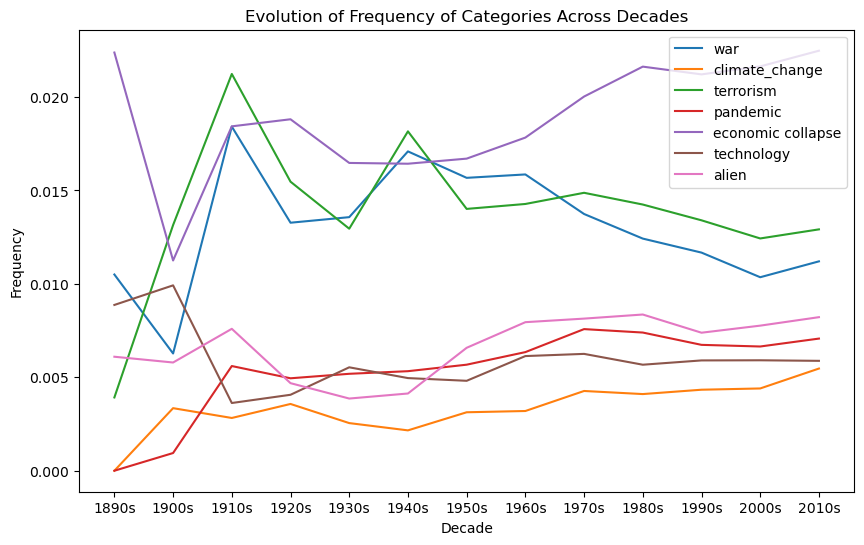

In [6]:
# Filter movies with score > 0 for at least one fear category
filtered_movies = all_movies_lexicon[all_movies_lexicon[fear_categories].apply(lambda x: x > 0).any(axis=1)]

# Print percentage of movies for which we don't have the release date
print("Percentage of movies for which we don't have the release date: {:.2f}%".format(100 * filtered_movies['Movie release date'].isnull().sum() / len(filtered_movies)))
# Drop movies for which we don't have the release date
filtered_movies = filtered_movies.dropna(subset=['Movie release date'])

# Group the movies by decade and calculate the mean frequency for each category
filtered_movies['Movie release date'] = filtered_movies['Movie release date'].astype(int)
filtered_movies['Decade'] = filtered_movies['Movie release date'].apply(lambda x: x- (x % 10))
category_freq_by_decade_mean = filtered_movies.groupby('Decade')[fear_categories].mean() # Du sens de faire la mean ici alors qu'il 

# Plot the evolution of frequency for each category
plt.figure(figsize=(10, 6))
for category in fear_categories:
    plt.plot(category_freq_by_decade_mean.index, category_freq_by_decade_mean[category], label=category)


plt.xlabel('Decade')
# x tick labels with 1890s, 1900s, etc.
plt.xticks(category_freq_by_decade_mean.index, ['{}s'.format(decade) for decade in category_freq_by_decade_mean.index])
plt.ylabel('Frequency')
plt.title('Evolution of Frequency of Categories Across Decades')
plt.legend()
plt.show()


## 7.2 Link between fear categories

### Sentiment analysis

We analyze the different sentiments that are present in movies depicting societal fears.

In [7]:
analyzer = SentimentIntensityAnalyzer()

In [8]:
# Compute polarity scores for each movie summary
all_movies_lexicon['sentiment'] = all_movies_lexicon['Summary'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

### Link graph

We analyze the links between the different fear categories

In [185]:
all_movies_lexicon.head()
all_movies_lexicon_graph = all_movies_lexicon.copy()

/var/folders/_x/0l8g7_k500xbjv2lxq_rdbvc0000gn/T/ipykernel_25812/4068448731.py:30: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.78947368]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



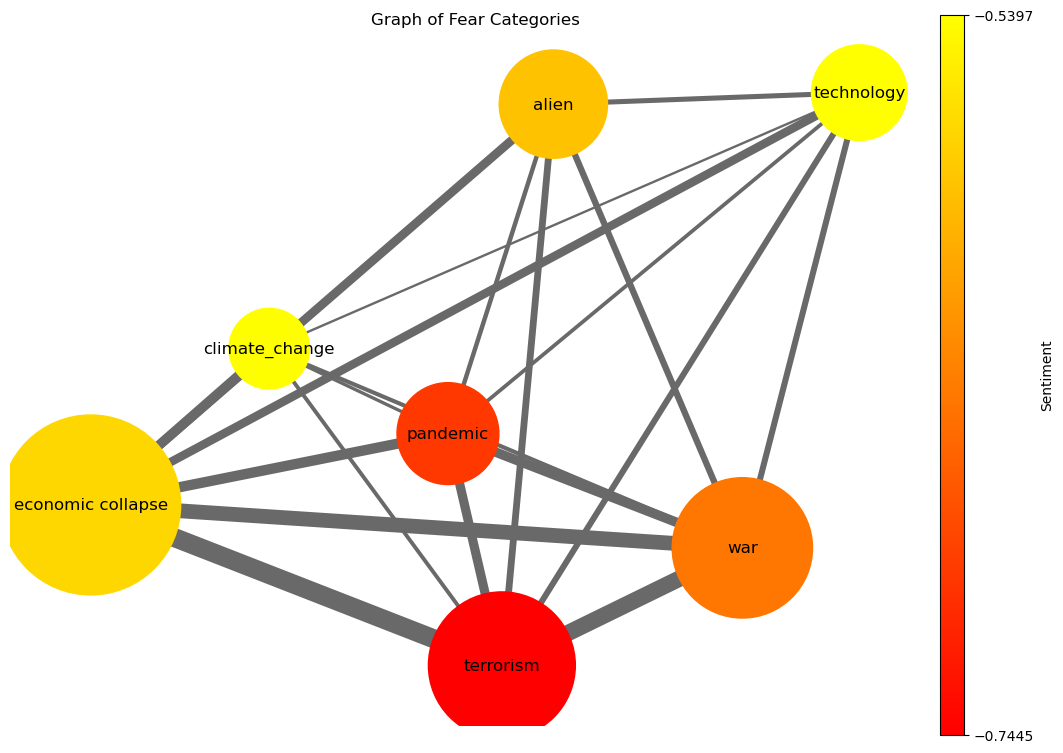

In [186]:
# Create a link graph
G = nx.Graph()
seed = 2

# Compute the mean frequency of each category
category_freq = all_movies_lexicon_graph[fear_categories].mean()

# Add a node for each fear category, the size of the node is proportional to the mean frequency of the category
for fear in fear_categories:
    G.add_node(fear, size=category_freq[fear])

# Create a dataframe that contain all the combinations of categories and a column for a score according to the number of movies that have both categories
link_table = pd.DataFrame(columns=['category1', 'category2', 'common_movies', 'common_words'])
for i in range(len(fear_categories)):
    for j in range(i+1, len(fear_categories)):
        category1 = fear_categories[i]
        category2 = fear_categories[j]
        common_movies= 0
        common_words = 0
        row_to_add = [category1, category2, common_movies, common_words]
        link_table.loc[len(link_table.index)] = row_to_add

# For each movie, if the movie has both categories, add 1 to the score of the link between the two categories
for index, row in all_movies_lexicon_graph.iterrows():
    for i in range(len(fear_categories)):
        for j in range(i+1, len(fear_categories)):
            category1 = fear_categories[i]
            category2 = fear_categories[j]
            if row[category1] != 0 and row[category2] != 0:
                link_table.loc[(link_table['category1'] == category1) & (link_table['category2'] == category2), 'common_movies'] += 20*(row[category1] + row[category2])


# Compute the number of common words between two categores
for index, row in link_table.iterrows():
    category1 = row['category1']
    category2 = row['category2']
    set_a = set(lexicon.cats[category1])
    set_b = set(lexicon.cats[category2])
    link_table.loc[(link_table['category1'] == category1) & (link_table['category2'] == category2), 'common_words'] = len(set_a & set_b)


# Create a dataframe with all categories and their the mean sentiment score of each category
sentiment_table = pd.DataFrame(columns=['category', 'sentiment'])
for category in fear_categories:
    category_sentiment = all_movies_lexicon_graph[all_movies_lexicon_graph[category] != 0]['sentiment'].mean()
    row_to_add = [category, category_sentiment]
    sentiment_table.loc[len(sentiment_table.index)] = row_to_add

# Change the color of the node according to the sentiment score of the category
min_sentiment = sentiment_table['sentiment'].min()
max_sentiment = sentiment_table['sentiment'].max()

for index, row in sentiment_table.iterrows():
    sentiment = row['sentiment']

    # Use a colormap to map the sentiment to a color
    color = cm.autumn((sentiment - min_sentiment) / (max_sentiment - min_sentiment))

    G.nodes[row['category']]['color'] = color


# Add an edge between two categories if they have at least one common word, and weight the edge with the number of common words
for index, row in link_table.iterrows():
    if row['common_words'] > 0:
        G.add_edge(row['category1'], row['category2'], weight=row['common_words'])
pos = nx.spring_layout(G, seed=seed) # Position nodes using Fruchterman-Reingold force-directed algorithm, based on edges corresponding to the common words

# Remove all edges
G.remove_edges_from(list(G.edges()))

# Add an edge between two categories if the score is greater than 0, and weight the edge with the common_movies score, those edge will be displayed
for index, row in link_table.iterrows():
    if row['common_movies'] > 0:
        G.add_edge(row['category1'], row['category2'], weight=row['common_movies'])

# Draw the graph with a colorbar
plt.figure(figsize=(12, 9))
node_colors = [G.nodes[node]['color'] for node in G.nodes()]
nodes = nx.draw_networkx_nodes(G, pos, node_size=[G.nodes[node]['size']*1000000 for node in G.nodes()], node_color=node_colors)
edges = nx.draw_networkx_edges(G, pos, width=[G.edges[edge]['weight']/1000 for edge in G.edges()], edge_color='dimgray')
nx.draw_networkx_labels(G, pos)
plt.axis('off')
plt.title('Graph of Fear Categories')

# Create a colorbar based on sentiment values
norm = Normalize(vmin=min_sentiment, vmax=max_sentiment)
sm = plt.cm.ScalarMappable(cmap=cm.autumn, norm=norm)
sm.set_array([])  # Required for ScalarMappable

# Create an axis for the colorbar
cax = plt.axes([0.9, 0.1, 0.02, 0.8])  # Adjust the position as needed
cbar = plt.colorbar(sm, cax=cax, ticks=[min_sentiment, max_sentiment])  # Specify tick locations

cbar.set_label('Sentiment')

plt.show()

The above graph should be interpreted the following way:
- The size of the nodes is proportional to the mean frequency of the category
- The distance between the nodes is proportional to the similarity between the lexicals
- The size of the links connecting the nodes is proportional to the number of movies that have non-zero values in both lexicons
- The color of the node represents the mean sentiment for this category

We can derive several conclusions from the observation of the graph:
- The lexicons of war and pandemic are the most similar lexicons, both in their lexicons definition and in the movies they contain
- All fear lexicons have a negative mean sentiment. War, pandemic and terrorism are the fear categories that have the most negative mean sentiment, while technology has the least negative mean sentiment.
- The nodes of war and pandemic are both close together and strongly connected. Thus, these topics seem to be often presented in a similar ways in our dataset.
- Alien is the most isolated topic.

## 7.3 Analysis of fears

To further analyze how fear are represented in movies, we need to select the movies that are the closest to each lexicon.\
To do this, different methods are possible:
- Take the top k films that have the highest frequency value for the category
- Take the top p% films that have the highest frequency value for the category
- Take all movies that have a frequency above a certain threshold t
- Derive an algorithm that would return the optimal number of movies to take into account for each category

In [11]:
# parameters for the optimization search
lower = 2500
upper = 6000
sim_func = hotelling_similarity

Searching for the best k value for war
Aggregate method:max_agg
Best k found: 4435
Aggregate method:min_agg
Best k found: 5846
Aggregate method:mean_agg
Best k found: 4902
Aggregate method:median_agg
Best k found: 5107
Aggregate method:sum_agg
Best k found: 4902


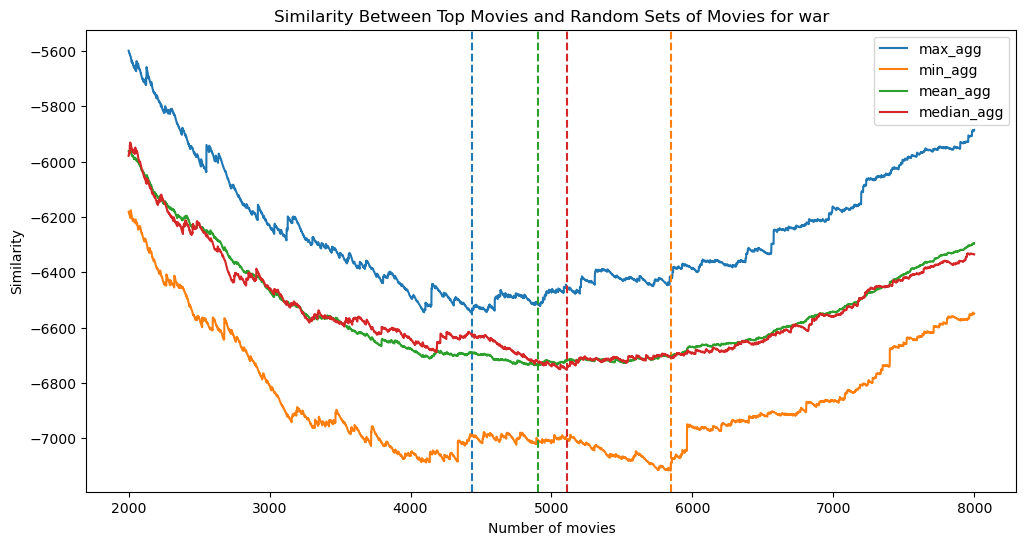

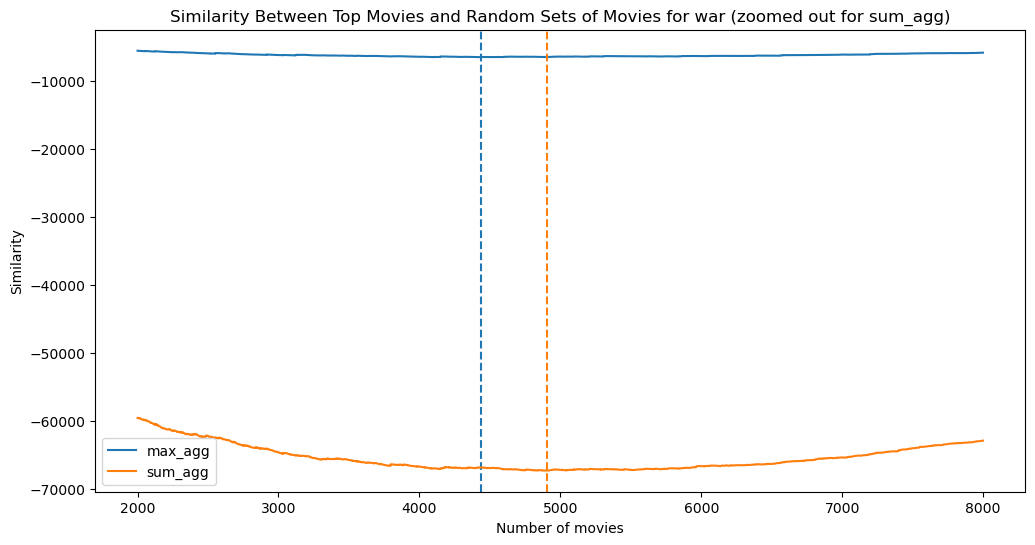

Searching for the best k value for climate_change
Aggregate method:max_agg
Best k found: 3448
Aggregate method:min_agg
Best k found: 2716
Aggregate method:mean_agg


KeyboardInterrupt: 

In [12]:
for category in fear_categories:
    print('Searching for the best k value for ' + category)
    sims = []
    aggs = [max_agg, min_agg, mean_agg, median_agg, sum_agg]
    best_ks = []
    for agg in aggs:
        print('Aggregate method:' + agg.__name__)
        top_war_movies, sim = top_optimize(all_movies_lexicon, category, sim_func, lower, upper, agg, r=10)
        sims.append(sim)
        best_k = len(top_war_movies)
        best_ks.append(best_k)
        print('Best k found: ' + str(best_k))

    #plot the similarities
    plt.figure(figsize=(12, 6))
    for sim in sims:
        agg = aggs[sims.index(sim)].__name__
        if agg != 'sum_agg':
            plt.plot(range(lower, upper), sim, label=agg)
            plt.axvline(best_ks[sims.index(sim)], color=plt.gca().lines[-1].get_color(), linestyle='--')
    plt.xlabel('Number of movies')
    plt.ylabel('Similarity')
    plt.title('Similarity Between Top Movies and Random Sets of Movies for ' + category)
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    for sim in sims:
        agg = aggs[sims.index(sim)].__name__
        if agg == 'sum_agg' or agg == 'max_agg':
            plt.plot(range(lower, upper), sim, label=agg)
            plt.axvline(best_ks[sims.index(sim)], color=plt.gca().lines[-1].get_color(), linestyle='--')
    plt.xlabel('Number of movies')
    plt.ylabel('Similarity')
    plt.title('Similarity Between Top Movies and Random Sets of Movies for ' + category + ' (zoomed out for sum_agg)')
    plt.legend()
    plt.show()

# 8. Study case: War movies
Let's study more the war theme in the movie datastet!

### Analysis on war lexicons

Since the two countries that produce the most film are USA and India, let's see if there is a correlation between the frequence of the war lexicon and their respective major war.

In [157]:
# Dataframe with only movies from USA and India
all_movies_lexicon_usa = all_movies_lexicon[all_movies_lexicon['Movie countries'].apply(lambda countries: 'United States of America' in countries)]
all_movies_lexicon_india = all_movies_lexicon[all_movies_lexicon['Movie countries'].apply(lambda countries: 'India' in countries)]

# Drop nan values in the 'Movie release date' column
all_movies_lexicon_usa = all_movies_lexicon_usa.dropna(subset=['Movie release date'])
all_movies_lexicon_india = all_movies_lexicon_india.dropna(subset=['Movie release date'])

# Group the movies by 5 years and calculate the mean frequency for each category for usa
all_movies_lexicon_usa['Movie release date'] = all_movies_lexicon_usa['Movie release date'].astype(int)
all_movies_lexicon_usa['Five'] = all_movies_lexicon_usa['Movie release date'].apply(lambda x: x- (x % 5))
category_freq_by_decade_usa = all_movies_lexicon_usa.groupby('Five')[fear_categories].mean() 

# Group the movies by 5 years and calculate the mean frequency for each category for india
all_movies_lexicon_india['Movie release date'] = all_movies_lexicon_india['Movie release date'].astype(int)
all_movies_lexicon_india['Five'] = all_movies_lexicon_india['Movie release date'].apply(lambda x: x- (x % 5))
category_freq_by_decade_india = all_movies_lexicon_india.groupby('Five')[fear_categories].mean()

#### Plot of the result for the USA :

In [159]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=category_freq_by_decade_usa.index, y=category_freq_by_decade_usa['War'], name='War', line=dict(color='black')))
fig.add_trace(go.Scatter(x=[1914, 1918], y=[0.010, 0.010], fill='tozeroy', mode='none', fillcolor='rgba(0,100,80,0.2)', showlegend=False))
fig.add_trace(go.Scatter(x=[1939, 1945], y=[0.010, 0.010], fill='tozeroy', mode='none', fillcolor='rgba(0,176,246,0.2)', showlegend=False))
fig.add_trace(go.Scatter(x=[1947, 1991], y=[0.010, 0.010], fill='tozeroy', mode='none', fillcolor='rgba(231,107,243,0.2)', showlegend=False))
fig.add_trace(go.Scatter(x=[1914, 1914], y=[0.00, 0.010], mode='lines', line=dict(color='rgb(0,100,80)', dash='dash'), name='WW1'))
fig.add_trace(go.Scatter(x=[1918, 1918], y=[0.00, 0.010], mode='lines', line=dict(color='rgb(0,100,80)', dash='dash'), showlegend=False))
fig.add_trace(go.Scatter(x=[1939, 1939], y=[0.000, 0.010], mode='lines', line=dict(color='rgb(0,176,246)', dash='dash'), name='WW2'))
fig.add_trace(go.Scatter(x=[1945, 1945], y=[0.000, 0.010], mode='lines', line=dict(color='rgb(0,176,246)', dash='dash'), showlegend=False))
fig.add_trace(go.Scatter(x=[1947, 1947], y=[0.000, 0.010], mode='lines', line=dict(color='rgb(231,107,243)', dash='dash'), name='Cold War'))
fig.add_trace(go.Scatter(x=[1991, 1991], y=[0.000, 0.010], mode='lines', line=dict(color='rgb(231,107,243)', dash='dash'), showlegend=False))
fig.update_layout(title='Frequency of the War Lexicon in American movies for every five years period',
                   xaxis_title='Time [Years]',
                   yaxis_title='Frequency of the War Lexicon [-]',
                   xaxis=dict(
        tickmode = 'array',
        ticktext = ['1914', '1918', '1939', '1945', '1947', '1991']
    ))

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'line': {'color': 'black'},
              'name': 'War',
              'type': 'scatter',
              'x': array([1890, 1895, 1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945,
                          1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005,
                          2010]),
              'y': array([0.        , 0.        , 0.        , 0.00284091, 0.00485172, 0.00749488,
                          0.00444264, 0.0051802 , 0.00458739, 0.00466336, 0.00936218, 0.00610212,
                          0.00812774, 0.00858556, 0.00758435, 0.00766433, 0.0065419 , 0.00680841,
                          0.00684475, 0.00617873, 0.00529067, 0.00533158, 0.0049456 , 0.00482507,
                          0.00509261])},
             {'fill': 'tozeroy',
              'fillcolor': 'rgba(0,100,80,0.2)',
              'mode': 'none',
              'showlegend': False,
              'type': 'scatter',
              'x': [1914, 1918],
              'y': [0.01, 0.01]},
             {'fill': 'tozeroy',
              'fillcolor': 'rgba(0,176,246,0.2)',
              'mode': 'none',
              'showlegend': False,
              'type': 'scatter',
              'x': [1939, 1945],
              'y': [0.01, 0.01]},
             {'fill': 'tozeroy',
              'fillcolor': 'rgba(231,107,243,0.2)',
              'mode': 'none',
              'showlegend': False,
              'type': 'scatter',
              'x': [1947, 1991],
              'y': [0.01, 0.01]},
             {'line': {'color': 'rgb(0,100,80)', 'dash': 'dash'},
              'mode': 'lines',
              'name': 'WW1',
              'type': 'scatter',
              'x': [1914, 1914],
              'y': [0.0, 0.01]},
             {'line': {'color': 'rgb(0,100,80)', 'dash': 'dash'},
              'mode': 'lines',
              'showlegend': False,
              'type': 'scatter',
              'x': [1918, 1918],
              'y': [0.0, 0.01]},
             {'line': {'color': 'rgb(0,176,246)', 'dash': 'dash'},
              'mode': 'lines',
              'name': 'WW2',
              'type': 'scatter',
              'x': [1939, 1939],
              'y': [0.0, 0.01]},
             {'line': {'color': 'rgb(0,176,246)', 'dash': 'dash'},
              'mode': 'lines',
              'showlegend': False,
              'type': 'scatter',
              'x': [1945, 1945],
              'y': [0.0, 0.01]},
             {'line': {'color': 'rgb(231,107,243)', 'dash': 'dash'},
              'mode': 'lines',
              'name': 'Cold War',
              'type': 'scatter',
              'x': [1947, 1947],
              'y': [0.0, 0.01]},
             {'line': {'color': 'rgb(231,107,243)', 'dash': 'dash'},
              'mode': 'lines',
              'showlegend': False,
              'type': 'scatter',
              'x': [1991, 1991],
              'y': [0.0, 0.01]}],
    'layout': {'template': '...',
               'title': {'text': 'Frequency of the War Lexicon in American movies for every five years period'},
               'xaxis': {'tickmode': 'array',
                         'ticktext': [1914, 1918, 1939, 1945, 1947, 1991],
                         'title': {'text': 'Time [Years]'}},
               'yaxis': {'title': {'text': 'Frequency of the War Lexicon [-]'}}}
})

For the American production, we can see from this graph that the war periods correponds to a peak in the frequency of the war lexicon. 

However, by grouping years by 5 years periods, the results are a little bit shifted. For exemple, all the years between 1940 and 1944 will be added to the 1940 point. Therefore, the exact location of the peaks regarding the dashed line representing the war is not very precise. 

Nevertheless, we can still conclude that each of these three main wars are related to a peak on the war lexicon use. For the Cold War which is the longest one, the peak seems to be present in the beginning of the war and then the frequency decreases. This could mean that the public interest on the war theme increases in the beginning of the war before decreasing if the war persist for a long time.

#### Plot of the result for India :

In [41]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=category_freq_by_decade_india.index, y=category_freq_by_decade_india['War Lexicon'], name='War Lexicon', line=dict(color='black')))
fig.add_trace(go.Scatter(x=[1947, 1948], y=[0.007, 0.007], fill='tozeroy', mode='none', fillcolor='rgba(0,100,80,0.2)', showlegend=False))
fig.add_trace(go.Scatter(x=[1999, 1999], y=[0.007, 0.007], fill='tozeroy', mode='none', fillcolor='rgba(231,107,243,0.2)', showlegend=False))
fig.add_trace(go.Scatter(x=[1947, 1947], y=[0.00, 0.007], mode='lines', line=dict(color='rgb(0,100,80)', dash='dash'), name='First war Between India and Pakistan'))
fig.add_trace(go.Scatter(x=[1948, 1948], y=[0.00, 0.007], mode='lines', line=dict(color='rgb(0,100,80)', dash='dash'), showlegend=False))
fig.add_trace(go.Scatter(x=[1965, 1965], y=[0.000, 0.007], mode='lines', line=dict(color='rgb(0,176,246)', dash='dash'), name='Second war Between India and Pakistan'))
fig.add_trace(go.Scatter(x=[1971, 1971], y=[0.000, 0.007], mode='lines', line=dict(color='rgb(255, 165, 0)', dash='dash'), name='Third war Between India and Pakistan'))
fig.add_trace(go.Scatter(x=[1999, 1999], y=[0.000, 0.007], mode='lines', line=dict(color='rgb(231,107,243)', dash='dash'), name='Kargil War'))
fig.update_layout(title='Frequency of the War Lexicon in Indian movies for every five years period',
                   xaxis_title='Time [Years]',
                   yaxis_title='Frequency of the War Lexicon [-]')
                   
fig.show()

For the Indian production, it seems like the different war doesn't really have an effect on the frequency of the war lexicon use. One explanation could be that the Bollywwod industry doesn't produce movies related to actual crises.

### Analysis on war genres

To further analyze our war movies, we look into movies that have a war-related genre. In other words, movies that have an assigned genre containing the word war.\
This analysis is only possible for the war fear category. Indeed, other fear categories don't have corresponding genres.

#### Sentiment Analysis 

In [161]:
# Select movies for which a genre in the list 'Movie genre' contain the word "war"
all_movies_war = all_movies_cleaned[all_movies_cleaned['Movie genres'].apply(lambda x: any(item for item in x if 'war' in item.lower()))]
# Drop nan values in the 'Summary' column
all_movies_war_summary = all_movies_war.dropna(subset=['Summary'])

In [163]:
analyzer = SentimentIntensityAnalyzer()

In [164]:
# Sentiment analysis on the summary
all_movies_war_summary['sentiment'] = all_movies_war_summary['Summary'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
all_movies_cleaned['sentiment'] = all_movies_cleaned['Summary'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

#### Histogram of the compound sentiment for war and all the movies

In [46]:
# Calculate histogram with fixed bin edges for war movies
counts_war, bin_edges_war = np.histogram(all_movies_war_summary['sentiment'], bins=20)
percentages_war = counts_war / len(all_movies_war_summary) * 100
bin_midpoints_war = (bin_edges_war[:-1] + bin_edges_war[1:]) / 2
histogram_data_war = pd.DataFrame({'Bin Midpoints': bin_midpoints_war, 'Percentage': percentages_war})

# Calculate histogram with fixed bin edges for all movies
counts_all, bin_edges_all = np.histogram(all_movies_cleaned['sentiment'], bins=20)
percentages_all = counts_all / len(all_movies_cleaned) * 100
bin_midpoints_all = (bin_edges_all[:-1] + bin_edges_all[1:]) / 2
histogram_data_all = pd.DataFrame({'Bin Midpoints': bin_midpoints_all, 'Percentage': percentages_all})

# Create subplots
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=['War Movies', 'All Movies'])

# Add bar chart for war movie
fig.add_trace(go.Bar(x=histogram_data_war['Bin Midpoints'], y=histogram_data_war['Percentage'], name='War Movies', marker_color='rgb(0, 114, 178)'),
              row=1, col=1)
fig.update_xaxes(title_text='Compound sentiment', row=1, col=1)
fig.update_yaxes(title_text='Movie Percentage [%]', row=1, col=1)  

# Add bar chart for all movie
fig.add_trace(go.Bar(x=histogram_data_all['Bin Midpoints'], y=histogram_data_all['Percentage'], name='All Movies', marker_color='rgb(230, 159, 0)'),
              row=1, col=2)
fig.update_xaxes(title_text='Compound sentiment', row=1, col=2)
fig.update_yaxes(title_text='Movie Percentage [%]', row=1, col=2, range=[0, 65])  

# Update layout
fig.update_layout(
   title_text='Histogram of Compound sentiment for war and all movies',
    showlegend=False 
)

fig.show()

These distrubutions are very different.
As it can be expected, the war movies have a higher percentage of really negative compound sentiment and a low percentage of positive compound sentiment compared to all the movies.

But are these differences statistically significant ? 

Let's perform a two-sided test for the null hypothesis that the war movies and all the movies have identical compound sentiment average (expected) values. 

In [47]:
#t-test to compare the two compound sentiment distributions
print(stats.ttest_ind(all_movies_war_summary['sentiment'], all_movies_cleaned['sentiment']))

TtestResult(statistic=-16.506914177361047, pvalue=5.006863490509746e-61, df=43767.0)


The p value is a lot smaller than 0.05, therefore we can reject the null hypothesis that the compound sentiment value is the same.

#### Time Evolution of Sentiment analysis

In [48]:
#drop nan values in the 'Movie release date' column
all_movies_summary = all_movies_summary.dropna(subset=['Movie release date'])
all_movies_war_summary = all_movies_war_summary.dropna(subset=['Movie release date'])

# Group the movies by year and calculate the mean frequency for each category
category_freq_by_year_all = all_movies_summary.groupby('Movie release date')[['sentiment']].mean()
category_freq_by_year_war = all_movies_war_summary.groupby('Movie release date')[['sentiment']].mean()

# Group the movies by 5 years and calculate the mean frequency for each category
all_movies_summary['Movie release date'] =all_movies_summary['Movie release date'].astype(int)
all_movies_summary['Decade'] = all_movies_summary['Movie release date'].apply(lambda x: x- (x % 5))
category_freq_by_decade_all = all_movies_summary.groupby('Decade')[['sentiment']].mean()

all_movies_war_summary['Movie release date'] = all_movies_war_summary['Movie release date'].astype(int)
all_movies_war_summary['Decade'] = all_movies_war_summary['Movie release date'].apply(lambda x: x- (x % 5))
category_freq_by_decade_war = all_movies_war_summary.groupby('Decade')[['sentiment']].mean()

#plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=category_freq_by_decade_all.index, y=category_freq_by_decade_all['sentiment'], name='All movies',  marker_color='rgb(0, 114, 178)'))
fig.add_trace(go.Scatter(x=category_freq_by_decade_war.index, y=category_freq_by_decade_war['sentiment'], name='War movies',  marker_color='rgb(230, 159, 0)'))
fig.add_vline(x=1939, line_width=3, line_dash="dash", line_color="gray", annotation_text="WW2")
fig.add_vline(x=1945, line_width=3, line_dash="dash", line_color="gray")
fig.update_layout(title='Evolution of Compound Sentiment Across Years', xaxis_title='Year', yaxis_title='Compound sentiment')
fig.show()

On this graph, we can see again that the compound sentiment is lower for the war movies than all the movies. But the second information which can be taken from this graph is that there is a drop on the compound sentiment value for all movies between 1930 and 1945. The same tendance can be seen for the war movies, but between 1935 and 1950. 

This could be linked to the political tension and the economical context of the Second World War period, which could encourage movie productions to create more movies inspired by negative sentiments.

#### IMDb Ratings

In [162]:
# Drop nan values on the Average ratings column
all_movies_ratings = all_movies_cleaned.dropna(subset=['averageRating'])
all_movies_war_ratings = all_movies_war.dropna(subset=['averageRating'])

Let's compare the histogram of the average rating between war movies and all movies

In [50]:
# Calculate histogram with fixed bin edges for war movies
counts_war, bin_edges_war = np.histogram(all_movies_war_ratings['averageRating'], bins=20)
percentages_war = counts_war / len(all_movies_war_ratings) * 100
bin_midpoints_war = (bin_edges_war[:-1] + bin_edges_war[1:]) / 2
histogram_data_war = pd.DataFrame({'Bin Midpoints': bin_midpoints_war, 'Percentage': percentages_war})

# Calculate histogram with fixed bin edges for all movies
counts_all, bin_edges_all = np.histogram(all_movies_ratings['averageRating'], bins=20)
percentages_all = counts_all / len(all_movies_ratings) * 100
bin_midpoints_all = (bin_edges_all[:-1] + bin_edges_all[1:]) / 2
histogram_data_all = pd.DataFrame({'Bin Midpoints': bin_midpoints_all, 'Percentage': percentages_all})

# Create subplots
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=['War Movies', 'All Movies'])

# Add bar chart for war movies
fig.add_trace(go.Bar(x=histogram_data_war['Bin Midpoints'], y=histogram_data_war['Percentage'], name='War Movies', marker_color='rgb(0, 114, 178)'),
              row=1, col=1)
fig.update_xaxes(title_text='Average Rating', range=[0, 10], row=1, col=1)
fig.update_yaxes(title_text='Percentage [%]',range=[0, 20], row=1, col=1)  

# Add bar chart for all movies
fig.add_trace(go.Bar(x=histogram_data_all['Bin Midpoints'], y=histogram_data_all['Percentage'], name='All Movies', marker_color='rgb(230, 159, 0)'),
              row=1, col=2)
fig.update_xaxes(title_text='Average Rating', range=[0, 10], row=1, col=2)
fig.update_yaxes(title_text='Percentage [%]', range=[0, 20], row=1, col=2) 

# Update layout
fig.update_layout(
   title_text='Histogram of Average Ratings for war and all movies',
    showlegend=False 
)

fig.show()

On these histograms, it looks like the average rating of the war movie is quiet close to the one from all the movies. Let's try to use a more precise representation.

We can also present these results as a boxplot

In [51]:
fig = go.Figure()
fig.add_trace(go.Box(y=all_movies_war_ratings['averageRating'], name='War movies', marker_color='rgb(0, 114, 178)'))
fig.add_trace(go.Box(y=all_movies_ratings['averageRating'], name='All movies',  marker_color='rgb(230, 159, 0)'))
fig.update_layout(title='Box plot of the average rating of war movies<br>and all movies',
                   yaxis_title='Average rating on a 10 points scale')
fig.update_layout(width=500, height=400 )
fig.show()

On these box plots, we can see that the average rating of the war movies is slightly higher than the one for all movies. The war movies also have a distrution less widespread and have less outliers.

Is the difference between the means statistically significant ? Let's perform a t-test! 

We perform a paired t-test on the ratings of the fear movies and all movies to see if they are statistically different.\
We use a paired t-test because we are comparing two samples of movies (top_fears_movies_ratings) with itself (all_movies_ratings) that come from the same set. \
Null hypothesis: the two samples have the same average (expected) value.

In [170]:
all_movies_sample = all_movies_ratings.sample(len(all_movies_war_ratings), random_state=None)
all_movies_sample = all_movies_sample.dropna(subset=['averageRating'])

t_statistic, p_value = stats.ttest_rel(all_movies_war_ratings['averageRating'], all_movies_sample['averageRating'])
print('Top 300 Fear Movies vs All Movies')
print('T-statistic:', t_statistic)
print('P-value:', p_value)

alpha = 0.05
if p_value < alpha:
    print('P-value < 0.05: We reject the null hypothesis.')
else:
    print('P-value > 0.05: We fail to reject the null hypothesis')


Top 300 Fear Movies vs All Movies
T-statistic: 11.377491425993707
P-value: 7.710161038239849e-29
P-value < 0.05: We reject the null hypothesis.


The p value is a lot smaller than 0.05, therefore we can reject the null hypothesis that the rating average value is the same for war-related movies and all the movies.